<a href="https://colab.research.google.com/github/AArashev/DTSC4050/blob/main/Nikkei_225_FINAL_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance


[*********************100%%**********************]  1 of 1 completed


Epoch 1/100
31/31 [==============================] - 2s 23ms/step - loss: 0.2528 - mean_absolute_error: 0.3581 - val_loss: 0.0729 - val_mean_absolute_error: 0.2071 - lr: 0.0010
Epoch 2/100
 9/31 [=======>......................] - ETA: 0s - loss: 0.1076 - mean_absolute_error: 0.2408

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 0s 16ms/step - loss: 0.0948 - mean_absolute_error: 0.2236 - val_loss: 0.0849 - val_mean_absolute_error: 0.2284 - lr: 0.0010
Epoch 3/100
31/31 [==============================] - 0s 16ms/step - loss: 0.0831 - mean_absolute_error: 0.2098 - val_loss: 0.0981 - val_mean_absolute_error: 0.2423 - lr: 0.0010
Epoch 4/100
31/31 [==============================] - 1s 16ms/step - loss: 0.0714 - mean_absolute_error: 0.1945 - val_loss: 0.0486 - val_mean_absolute_error: 0.1700 - lr: 5.0000e-04
Epoch 5/100
31/31 [==============================] - 0s 15ms/step - loss: 0.0682 - mean_absolute_error: 0.1892 - val_loss: 0.0785 - val_mean_absolute_error: 0.2191 - lr: 5.0000e-04
Epoch 6/100
31/31 [==============================] - 1s 16ms/step - loss: 0.0649 - mean_absolute_error: 0.1835 - val_loss: 0.0484 - val_mean_absolute_error: 0.1712 - lr: 5.0000e-04
Epoch 7/100
31/31 [==============================] - 1s 16ms/step - loss: 0.0593 - mean_absolute_error: 0.1784 - va

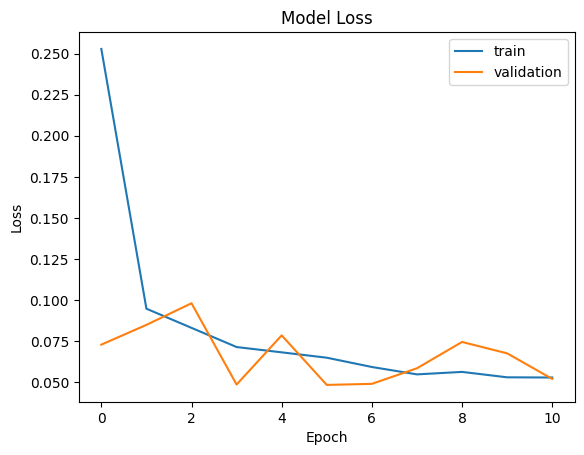

In [ ]:
from numpy.lib.stride_tricks import sliding_window_view
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Download data from Yahoo Finance
nikkei_data = yf.download("^N225", start="2013-01-01", end="2023-01-01")

# Calculate technical indicators
nikkei_data['MA50'] = nikkei_data['Close'].rolling(window=50).mean()
delta = nikkei_data['Close'].diff()
gain = (delta.where(delta > 0, 0)).fillna(0)
loss = (-delta.where(delta < 0, 0)).fillna(0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
nikkei_data['RSI'] = 100 - (100 / (1 + rs))
exp1 = nikkei_data['Close'].ewm(span=12, adjust=False).mean()
exp2 = nikkei_data['Close'].ewm(span=26, adjust=False).mean()
nikkei_data['MACD'] = exp1 - exp2
nikkei_data['MACD_signal'] = nikkei_data['MACD'].ewm(span=9, adjust=False).mean()
nikkei_data.fillna(method='bfill', inplace=True)

# Standardize all features
scaler = StandardScaler()
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'MA50', 'RSI', 'MACD', 'MACD_signal']
nikkei_data[features] = scaler.fit_transform(nikkei_data[features])

# Create windows for input data using sliding_window_view
window_size = 30
X = sliding_window_view(nikkei_data[features].values, window_shape=(window_size, len(features)))
X = X.reshape(X.shape[0], window_size, len(features))  # Reshape X to have the correct shape

# Align labels with input windows
y = nikkei_data['Close'][window_size-1:]

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

# Model architecture
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, len(features))),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='linear')
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Setup callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val),
                    callbacks=[early_stopping, lr_scheduler, checkpoint], verbose=1)

# Plotting
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [ ]:
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed

# Designing a sequence-to-sequence LSTM model
model = Sequential()
# Encoder
model.add(LSTM(100, activation='relu', input_shape=(window_size, 1)))
model.add(RepeatVector(prediction_size))
# Decoder
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))

model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100)               40800     
                                                                 
 repeat_vector_1 (RepeatVec  (None, 10, 100)           0         
 tor)                                                            
                                                                 
 lstm_3 (LSTM)               (None, 10, 100)           80400     
                                                                 
 time_distributed_1 (TimeDi  (None, 10, 1)             101       
 stributed)                                                      
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# LSTM

In [ ]:
window_size = 30
prediction_size = 10
X, y = [], []
for i in range(len(nikkei_data['Normalized']) - window_size - prediction_size + 1):
    X.append(nikkei_data['Normalized'][i:i+window_size])
    y.append(nikkei_data['Normalized'][i+window_size:i+window_size+prediction_size])

X = np.array(X)
y = np.array(y).reshape((len(y), prediction_size, 1))  # Reshape for LSTM

# Split data
X_train, X_val, y_train, Y_val = train_test_split(X, y, test_size=0.2, random_state=0)

# Build the LSTM model
model = Sequential([
    LSTM(100, activation='relu', input_shape=(window_size, 1)),
    RepeatVector(prediction_size),
    LSTM(100, activation='relu', return_sequences=True),
    TimeDistributed(Dense(1))
])
model.compile(optimizer='adam', loss='mse')
model.summary()

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, Y_val), callbacks=[early_stopping], verbose=1)

# Evaluate the model
def evaluate_model(y_true, y_pred):
    y_true_flattened = y_true.flatten()
    y_pred_flattened = y_pred.flatten()
    mae = mean_absolute_error(y_true_flattened, y_pred_flattened)
    mse = mean_squared_error(y_true_flattened, y_pred_flattened)
    return mae, mse

predicted_sequences = model.predict(X_val)
mae, mse = evaluate_model(Y_val, predicted_sequences)
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

KeyError: 'Normalized'

In [ ]:
# Assuming your data was scaled:
predicted_sequences_rescaled = scaler.inverse_transform(predicted_sequences.reshape(-1, 1)).reshape(predicted_sequences.shape)
actual_sequences_rescaled = scaler.inverse_transform(Y_val.reshape(-1, 1)).reshape(Y_val.shape)


NameError: name 'predicted_sequences' is not defined

NameError: name 'actual_sequences_rescaled' is not defined

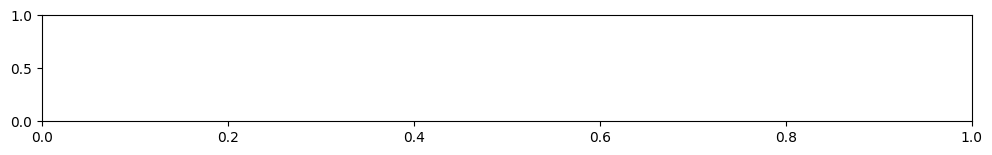

In [ ]:
import matplotlib.pyplot as plt

# Set the number of sequences to plot
num_sequences_to_plot = 5

plt.figure(figsize=(12, 8))
for i in range(num_sequences_to_plot):
    plt.subplot(num_sequences_to_plot, 1, i + 1)
    plt.plot(actual_sequences_rescaled[i], label='Actual')
    plt.plot(predicted_sequences_rescaled[i], linestyle='--', label='Predicted')
    plt.title(f'Sequence {i+1}')
    plt.ylabel('Stock Price')
    if i == 0:
        plt.legend()

plt.xlabel('Time Steps')
plt.tight_layout()
plt.show()
